# 从kaggle下载数据

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/kaggle.json /content/

In [ ]:
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c state-farm-distracted-driver-detection

100% 4.00G/4.00G [00:31<00:00, 162MB/s]
100% 4.00G/4.00G [00:31<00:00, 136MB/s]


In [ ]:
!unzip /content/state-farm-distracted-driver-detection.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: imgs/train/c7/img_56636.jpg  
  inflating: imgs/train/c7/img_56661.jpg  
  inflating: imgs/train/c7/img_56699.jpg  
  inflating: imgs/train/c7/img_56717.jpg  
  inflating: imgs/train/c7/img_56724.jpg  
  inflating: imgs/train/c7/img_56768.jpg  
  inflating: imgs/train/c7/img_56779.jpg  
  inflating: imgs/train/c7/img_56849.jpg  
  inflating: imgs/train/c7/img_56899.jpg  
  inflating: imgs/train/c7/img_56938.jpg  
  inflating: imgs/train/c7/img_5706.jpg  
  inflating: imgs/train/c7/img_57076.jpg  
  inflating: imgs/train/c7/img_57122.jpg  
  inflating: imgs/train/c7/img_57137.jpg  
  inflating: imgs/train/c7/img_5715.jpg  
  inflating: imgs/train/c7/img_57278.jpg  
  inflating: imgs/train/c7/img_57321.jpg  
  inflating: imgs/train/c7/img_57345.jpg  
  inflating: imgs/train/c7/img_57355.jpg  
  inflating: imgs/train/c7/img_5741.jpg  
  inflating: imgs/train/c7/img_57433.jpg  
  inflating: imgs/train/c7/img_5753.jpg  
  inflating: imgs/train/c7/img_

# 导入python包

In [ ]:
import pandas as pd
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import math
import skimage
import seaborn as sns
from sklearn import metrics

import tensorflow as tf

import matplotlib.pyplot as plt

import os
import PIL


import torch
from torch.utils.data import Dataset
from torchvision import datasets,models
from torchvision.transforms import ToTensor
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F

# 超参数定义

In [ ]:
img_height = 224
img_width = 224
batch_size = 8

# 数据处理pipline

## 生成dataset

In [ ]:
img_dir = '/content/imgs/train'

In [ ]:
train_transform = transforms.Compose([
                    transforms.RandomRotation(5),
                    transforms.RandomHorizontalFlip(),
                    transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])

In [ ]:
image_datasets = datasets.ImageFolder(img_dir,train_transform)
image_datasets

Dataset ImageFolder
    Number of datapoints: 22424
    Root location: /content/imgs/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-5.0, 5.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
image_datasets.classes

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [ ]:
num_classes = len(image_datasets.classes)
num_classes

10

In [ ]:
len(image_datasets)

22424

In [ ]:
# 准备mini数据集跑通流程
_, train_set, val_set = torch.utils.data.random_split(image_datasets, [0.8,0.16,0.04])

# 完整数据集
# train_set, val_set = torch.utils.data.random_split(image_datasets, [0.8,0.2])
len(train_set),len(val_set)

(3588, 896)

In [ ]:
len(image_datasets),len(train_set),len(val_set)

(22424, 3588, 896)

In [ ]:
image_datasets[0][0].shape, image_datasets[0][1]

(torch.Size([3, 224, 224]), 0)

## 生成dataloader

In [ ]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True,num_workers=2)
test_dataloader = DataLoader(val_set, batch_size=8, shuffle=False,num_workers=2)

In [ ]:
# Display image and label.
b_img_rgb, train_labels = next(iter(train_dataloader))
print(f"b_img_rgb batch shape: {b_img_rgb.size()}")
print(f"train_labels batch shape: {train_labels.size()}")


b_img_rgb batch shape: torch.Size([8, 3, 224, 224])
train_labels batch shape: torch.Size([8])


In [ ]:
train_labels

tensor([3, 9, 6, 0, 3, 9, 1, 9])

# 确定CPU GPU设备

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


In [ ]:
# Adam(params, lr=0.001

# 训练和评估循环

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (img_rgb, y) in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)
        img_rgb = img_rgb.to(device)

        y = y.to(device)

        # Compute prediction error
        pred = model(img_rgb)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 25 == 0:
            loss, current = loss.item(), batch * len(img_rgb)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (img_rgb, y) in dataloader:
            img_rgb = img_rgb.to(device)

            y = y.to(device)

            pred = model(img_rgb)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

# 三模型 融合 创新模型 efficientnet+resnet+Transformer

## 构建基础模型 efficientnet

In [ ]:

base_model_efficientnet_b0 = models.efficientnet_b0(pretrained=False)
base_model_efficientnet_b0.classifier[1] = nn.Linear(1280, 100)

base_model_efficientnet_b0.to(device)(b_img_rgb.to(device)).shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([8, 100])

## 构建基础模型 resnet18

In [ ]:

base_model_resnet18 = models.resnet18(pretrained=True)
num_ftrs = base_model_resnet18.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
base_model_resnet18.fc = nn.Linear(num_ftrs, 100)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]


## 构建基础模型 transformer

In [ ]:

base_model_vit_b_16 = models.vit_b_16(pretrained=True)
# base_model_vit_b_16.encoder.layers = base_model_vit_b_16.encoder.layers[:2]
base_model_vit_b_16.heads.head = nn.Linear(768, 100)

base_model_vit_b_16.to(device)(b_img_rgb.to(device)).shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 136MB/s]


torch.Size([8, 100])

## 合并得到大模型

In [ ]:
class ModeleBig(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model1 = base_model_resnet18
        self.base_model2 = base_model_efficientnet_b0
        self.base_model3 = base_model_vit_b_16

        encoder_layer = nn.TransformerEncoderLayer(d_model=100, nhead=2)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc1 = nn.Linear(300, 50)
        self.fc2 = nn.Linear(50, num_classes)
        self.flatten = nn.Flatten()


    def forward(self, img_rgb):
        # 模型一提取特征
        rgb_tensor1 = self.base_model1(img_rgb)

        # 模型二提取特征
        rgb_tensor2 = self.base_model2(img_rgb)

        # 模型三提取特征
        rgb_tensor3 = self.base_model3(img_rgb)

        # 合并特征并用Transformer encoder
        x = torch.stack([rgb_tensor1,rgb_tensor2,rgb_tensor3],dim=1)
        x = self.transformer_encoder(x)
        x = self.flatten(x)

        x = self.fc1(x)
        x = self.fc2(x)
        return x

model_big = ModeleBig().to(device)
model_big(b_img_rgb.to(device)).shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([8, 10])

In [ ]:
model_big

ModeleBig(
  (base_model1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

## 分配损失函数和优化器

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_big.parameters(), lr=3e-4)

## 训练和评估

In [ ]:
%%time
best_acc = 0.0  # 初始化最佳准确率
best_model_path = 'best_model.pth'  # 设置保存最佳模型的路径

epochs = 5
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_big, loss_fn, optimizer)

    train_loss, train_correct = test(train_dataloader, model_big, loss_fn)
    test_loss, test_correct = test(test_dataloader, model_big, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)

    # 检查是否为最佳模型
    if test_correct > best_acc:
        best_acc = test_correct
        torch.save(model_big.state_dict(), best_model_path)
        print(f"Saved Better Model at Epoch {t+1} with Accuracy: {best_acc}")

# 加载最佳模型权重
model_big.load_state_dict(torch.load(best_model_path))

# 将模型设置为评估模式
model_big.eval()

print("Done!")


Epoch 1
-------------------------------
loss: 2.373243  [    0/ 3588]
loss: 2.393457  [  200/ 3588]
loss: 1.636886  [  400/ 3588]
loss: 1.951291  [  600/ 3588]
loss: 1.139407  [  800/ 3588]
loss: 0.728297  [ 1000/ 3588]
loss: 1.483716  [ 1200/ 3588]
loss: 0.867575  [ 1400/ 3588]
loss: 0.684914  [ 1600/ 3588]
loss: 0.305344  [ 1800/ 3588]
loss: 0.663306  [ 2000/ 3588]
loss: 0.594795  [ 2200/ 3588]
loss: 0.236699  [ 2400/ 3588]
loss: 0.683936  [ 2600/ 3588]
loss: 0.557572  [ 2800/ 3588]
loss: 0.741264  [ 3000/ 3588]
loss: 0.667339  [ 3200/ 3588]
loss: 0.652152  [ 3400/ 3588]
Test Error: 
 Accuracy: 82.6%, Avg loss: 0.587706 

Test Error: 
 Accuracy: 82.1%, Avg loss: 0.634261 

Saved Better Model at Epoch 1 with Accuracy: 0.8214285714285714
Epoch 2
-------------------------------
loss: 0.298424  [    0/ 3588]
loss: 0.515175  [  200/ 3588]
loss: 1.066602  [  400/ 3588]
loss: 0.181278  [  600/ 3588]
loss: 0.432200  [  800/ 3588]
loss: 0.142550  [ 1000/ 3588]
loss: 0.194239  [ 1200/ 3588]
lo

### 模型验证集预测

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
# for image_batch, labels_batch in dataloaders['val']:
for (img_rgb, y) in test_dataloader:
    img_rgb = img_rgb.to(device)
    y = y.to(device)

    predict_score = model_big(img_rgb)
    predict_pro = m_softmax(predict_score)

    predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

    predict_pro_list.append(predict_pro.detach().cpu().numpy())
    predict_list.append(predict_label)
    label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([2.3853343e-02, 1.2431197e-03, 7.3873112e-04, 9.7812223e-01,
        1.7323536e-03], dtype=float32),
 array([6, 7, 2, 1, 7]),
 array([6, 7, 2, 1, 7]))

### 分类报告

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      0.842     0.950     0.893       101
           1      0.933     1.000     0.966        70
           2      0.978     0.946     0.962        93
           3      1.000     0.959     0.979        97
           4      0.957     0.967     0.962        91
           5      1.000     0.989     0.994        87
           6      0.943     0.992     0.967       133
           7      0.864     1.000     0.927        70
           8      0.939     0.765     0.844        81
           9      0.932     0.753     0.833        73

    accuracy                          0.938       896
   macro avg      0.939     0.932     0.933       896
weighted avg      0.940     0.938     0.936       896



### 混淆矩阵

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[ 96,   1,   0,   0,   0,   0,   0,   0,   1,   3],
       [  0,  70,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  88,   0,   0,   0,   1,   4,   0,   0],
       [  1,   2,   0,  93,   1,   0,   0,   0,   0,   0],
       [  3,   0,   0,   0,  88,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,  86,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0, 132,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  70,   0,   0],
       [  2,   0,   2,   0,   3,   0,   7,   4,  62,   1],
       [ 11,   1,   0,   0,   0,   0,   0,   3,   3,  55]])

<Axes: >

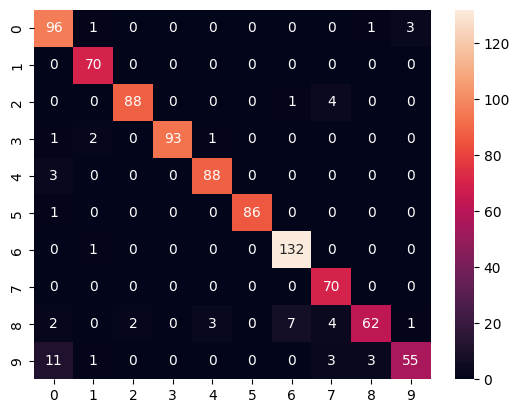

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

<Axes: >

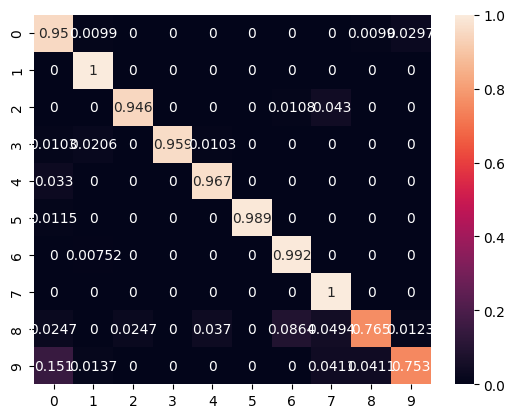

In [ ]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3g')

# 模型 CNN

## 构建基础模型

In [ ]:
class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 32, 3)
        self.fc1 = nn.Linear(4608, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


cnn_model = BaseModel().to(device)

cnn_model(b_img_rgb.to(device)).shape

torch.Size([8, 10])

## 分配损失函数和优化器

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

## 训练和评估

In [ ]:
epochs = 3
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, cnn_model, loss_fn, optimizer)

    train_loss, train_correct = test(train_dataloader, cnn_model, loss_fn)
    test_loss, test_correct = test(test_dataloader, cnn_model, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)
print("Done!")

Epoch 1
-------------------------------
loss: 2.264936  [    0/ 3588]
loss: 2.291675  [  200/ 3588]
loss: 2.295505  [  400/ 3588]
loss: 2.293788  [  600/ 3588]
loss: 2.320493  [  800/ 3588]
loss: 2.312200  [ 1000/ 3588]
loss: 2.309515  [ 1200/ 3588]
loss: 2.326254  [ 1400/ 3588]
loss: 2.322955  [ 1600/ 3588]
loss: 2.287912  [ 1800/ 3588]
loss: 2.279972  [ 2000/ 3588]
loss: 2.305766  [ 2200/ 3588]
loss: 2.344584  [ 2400/ 3588]
loss: 2.299844  [ 2600/ 3588]
loss: 2.267189  [ 2800/ 3588]
loss: 2.302434  [ 3000/ 3588]
loss: 2.305610  [ 3200/ 3588]
loss: 2.304852  [ 3400/ 3588]
Test Error: 
 Accuracy: 10.8%, Avg loss: 2.298954 

Test Error: 
 Accuracy: 10.4%, Avg loss: 2.296504 

Epoch 2
-------------------------------
loss: 2.307858  [    0/ 3588]
loss: 2.263208  [  200/ 3588]
loss: 2.257405  [  400/ 3588]
loss: 2.290227  [  600/ 3588]
loss: 2.337358  [  800/ 3588]
loss: 2.248023  [ 1000/ 3588]
loss: 2.334626  [ 1200/ 3588]
loss: 2.284182  [ 1400/ 3588]
loss: 2.307658  [ 1600/ 3588]
loss: 

## 可视化训练过程

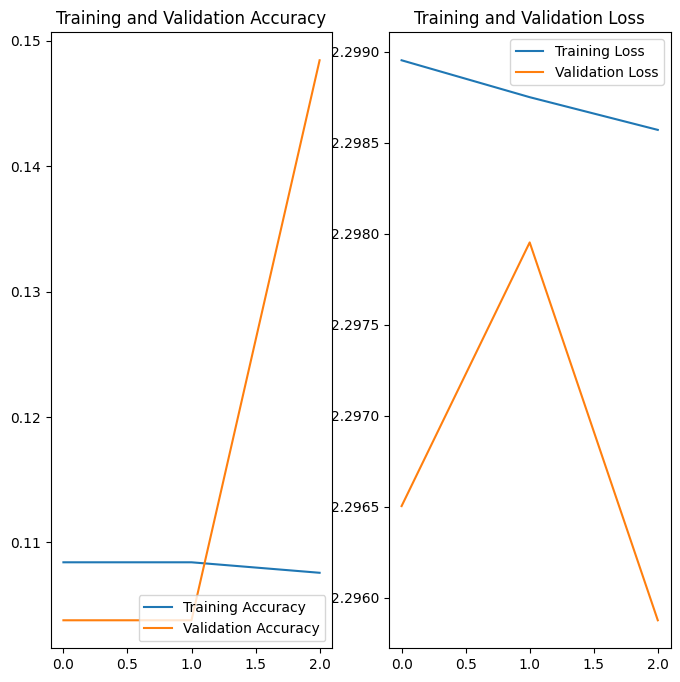

In [ ]:
# train_loss_array,train_acc_array,val_loss_array,val_acc_array
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 模型验证集预测

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
for (img_rgb, y) in test_dataloader:
    img_rgb = img_rgb.to(device)
    y = y.to(device)

    predict_score = cnn_model(img_rgb)
    predict_pro = m_softmax(predict_score)

    predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

    predict_pro_list.append(predict_pro.detach().cpu().numpy())
    predict_list.append(predict_label)
    label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([0.10534689, 0.10534689, 0.10534689, 0.10534689, 0.10534689],
       dtype=float32),
 array([6, 6, 6, 6, 6]),
 array([6, 7, 2, 1, 7]))

### 分类报告

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       101
           1      0.000     0.000     0.000        70
           2      0.000     0.000     0.000        93
           3      0.000     0.000     0.000        97
           4      0.000     0.000     0.000        91
           5      0.000     0.000     0.000        87
           6      0.148     1.000     0.259       133
           7      0.000     0.000     0.000        70
           8      0.000     0.000     0.000        81
           9      0.000     0.000     0.000        73

    accuracy                          0.148       896
   macro avg      0.015     0.100     0.026       896
weighted avg      0.022     0.148     0.038       896



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 混淆矩阵

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[  0,   0,   0,   0,   0,   0, 101,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  70,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  93,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  97,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  91,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  87,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 133,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  70,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  81,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  73,   0,   0,   0]])

<Axes: >

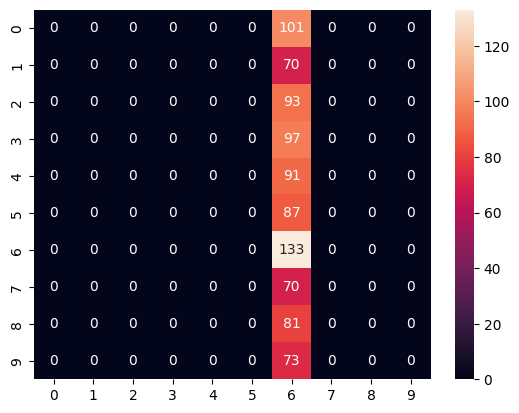

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

<Axes: >

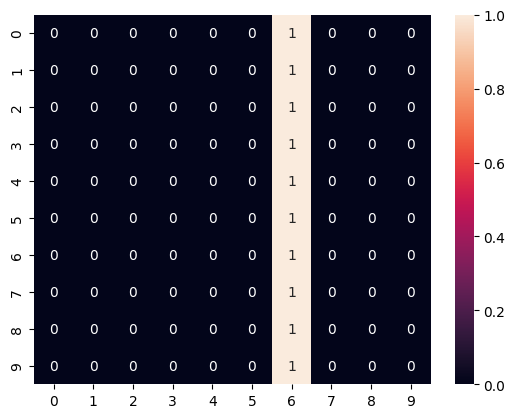

In [ ]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3g')

# 模型 resnet18

## 构建基础模型

In [ ]:

base_model_resnet18 = models.resnet18(pretrained=True)
num_ftrs = base_model_resnet18.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
base_model_resnet18.fc = nn.Linear(num_ftrs, num_classes)

base_model_resnet18 = base_model_resnet18.to(device)

base_model_resnet18(b_img_rgb.to(device)).shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([8, 10])

In [ ]:
base_model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 分配损失函数和优化器

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(base_model_resnet18.parameters(), lr=1e-3)

## 训练和评估

In [ ]:
epochs = 5
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, base_model_resnet18, loss_fn, optimizer)

    train_loss, train_correct = test(train_dataloader, base_model_resnet18, loss_fn)
    test_loss, test_correct = test(test_dataloader, base_model_resnet18, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)
print("Done!")

Epoch 1
-------------------------------
loss: 2.589137  [    0/ 3588]
loss: 2.245541  [  200/ 3588]
loss: 2.177016  [  400/ 3588]
loss: 2.247701  [  600/ 3588]
loss: 2.242126  [  800/ 3588]
loss: 2.260768  [ 1000/ 3588]
loss: 2.003018  [ 1200/ 3588]
loss: 2.165720  [ 1400/ 3588]
loss: 2.340578  [ 1600/ 3588]
loss: 2.238824  [ 1800/ 3588]
loss: 1.988544  [ 2000/ 3588]
loss: 1.810114  [ 2200/ 3588]
loss: 2.060209  [ 2400/ 3588]
loss: 1.910273  [ 2600/ 3588]
loss: 1.908743  [ 2800/ 3588]
loss: 2.043072  [ 3000/ 3588]
loss: 1.954512  [ 3200/ 3588]
loss: 1.951549  [ 3400/ 3588]
Test Error: 
 Accuracy: 58.6%, Avg loss: 1.657823 

Test Error: 
 Accuracy: 60.5%, Avg loss: 1.653271 

Epoch 2
-------------------------------
loss: 1.716994  [    0/ 3588]
loss: 1.744165  [  200/ 3588]
loss: 1.819452  [  400/ 3588]
loss: 1.456272  [  600/ 3588]
loss: 1.274704  [  800/ 3588]
loss: 1.829153  [ 1000/ 3588]
loss: 1.588658  [ 1200/ 3588]
loss: 1.501323  [ 1400/ 3588]
loss: 1.580130  [ 1600/ 3588]
loss: 

## 可视化训练过程

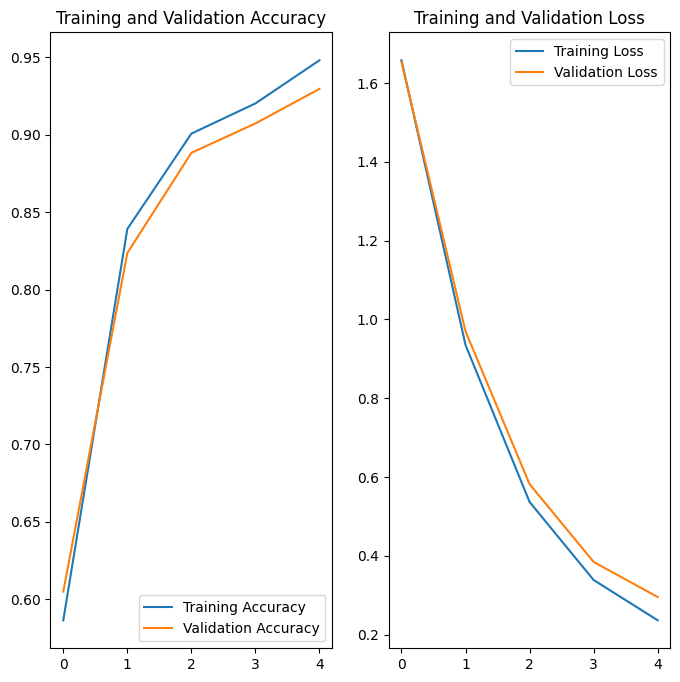

In [ ]:
# train_loss_array,train_acc_array,val_loss_array,val_acc_array
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 模型验证集预测

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
for (img_rgb, y) in test_dataloader:
    img_rgb = img_rgb.to(device)
    y = y.to(device)

    predict_score = base_model_resnet18(img_rgb)
    predict_pro = m_softmax(predict_score)

    predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

    predict_pro_list.append(predict_pro.detach().cpu().numpy())
    predict_list.append(predict_label)
    label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([0.09461993, 0.00552156, 0.00112373, 0.9292911 , 0.0039127 ],
       dtype=float32),
 array([6, 7, 2, 1, 7]),
 array([6, 7, 2, 1, 7]))

### 分类报告

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      0.887     0.931     0.908       101
           1      0.933     1.000     0.966        70
           2      0.929     0.978     0.953        93
           3      0.979     0.969     0.974        97
           4      0.910     1.000     0.953        91
           5      1.000     0.977     0.988        87
           6      0.949     0.977     0.963       133
           7      0.932     0.971     0.951        70
           8      0.946     0.654     0.774        81
           9      0.914     0.877     0.895        73

    accuracy                          0.938       896
   macro avg      0.938     0.934     0.932       896
weighted avg      0.938     0.938     0.935       896



### 混淆矩阵

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[ 94,   2,   0,   2,   2,   0,   0,   0,   0,   1],
       [  0,  70,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  91,   0,   0,   0,   0,   0,   0,   2],
       [  0,   0,   0,  94,   2,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0,  91,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,  85,   0,   0,   0,   1],
       [  0,   2,   0,   0,   0,   0, 130,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,  68,   1,   1],
       [  4,   0,   7,   0,   5,   0,   6,   5,  53,   1],
       [  7,   1,   0,   0,   0,   0,   1,   0,   0,  64]])

<Axes: >

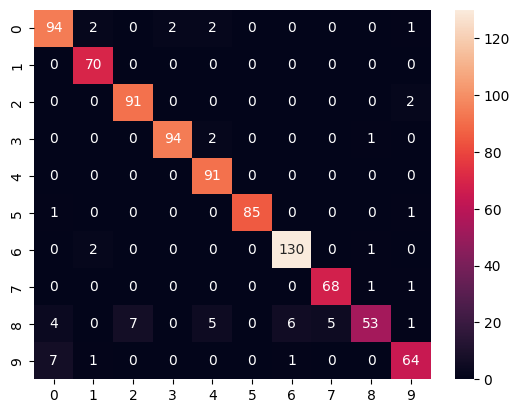

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

<Axes: >

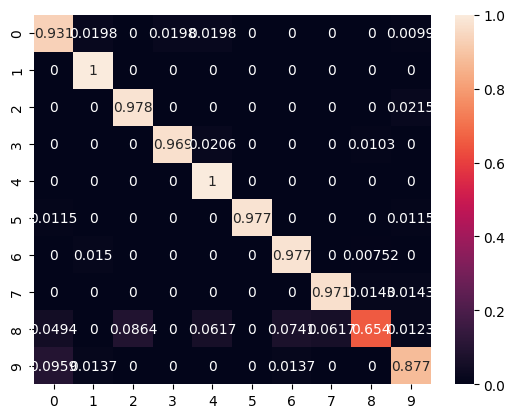

In [ ]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3g')

## 模型权重保存

In [ ]:
# 保存模型权重
# torch.s base_model_resnet18

In [ ]:
torch.save(base_model_resnet18.state_dict(), "model_danger_pose.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
!cp  model_danger_pose.pth /content/drive/MyDrive/

# 模型 vgg13

## 构建基础模型

In [ ]:

base_model_vgg13 = models.vgg13(pretrained=True)

base_model_vgg13.classifier[-1] = nn.Linear(4096, num_classes)

base_model_vgg13.to(device)(b_img_rgb.to(device)).shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth
100%|██████████| 508M/508M [00:15<00:00, 33.9MB/s]


torch.Size([8, 10])

In [ ]:
base_model_vgg13

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

## 分配损失函数和优化器

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(base_model_vgg13.parameters(), lr=1e-3)

## 训练和评估

In [ ]:
epochs = 2
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, base_model_vgg13, loss_fn, optimizer)

    train_loss, train_correct = test(train_dataloader, base_model_vgg13, loss_fn)
    test_loss, test_correct = test(test_dataloader, base_model_vgg13, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)
print("Done!")

Epoch 1
-------------------------------
loss: 2.339913  [    0/ 3588]
loss: 2.074587  [  200/ 3588]
loss: 2.081143  [  400/ 3588]
loss: 2.372238  [  600/ 3588]
loss: 2.365685  [  800/ 3588]
loss: 2.176127  [ 1000/ 3588]
loss: 2.203704  [ 1200/ 3588]
loss: 2.463404  [ 1400/ 3588]
loss: 2.095060  [ 1600/ 3588]
loss: 2.040800  [ 1800/ 3588]
loss: 2.129309  [ 2000/ 3588]
loss: 2.377977  [ 2200/ 3588]
loss: 1.769573  [ 2400/ 3588]
loss: 1.576367  [ 2600/ 3588]
loss: 1.785822  [ 2800/ 3588]
loss: 1.148043  [ 3000/ 3588]
loss: 1.424401  [ 3200/ 3588]
loss: 1.280968  [ 3400/ 3588]
Test Error: 
 Accuracy: 69.3%, Avg loss: 1.092040 

Test Error: 
 Accuracy: 65.1%, Avg loss: 1.182435 

Epoch 2
-------------------------------
loss: 0.847272  [    0/ 3588]
loss: 0.985760  [  200/ 3588]
loss: 0.757939  [  400/ 3588]
loss: 0.602805  [  600/ 3588]
loss: 0.890849  [  800/ 3588]
loss: 1.085758  [ 1000/ 3588]
loss: 0.426035  [ 1200/ 3588]
loss: 0.566003  [ 1400/ 3588]
loss: 0.389970  [ 1600/ 3588]
loss: 

## 可视化训练过程

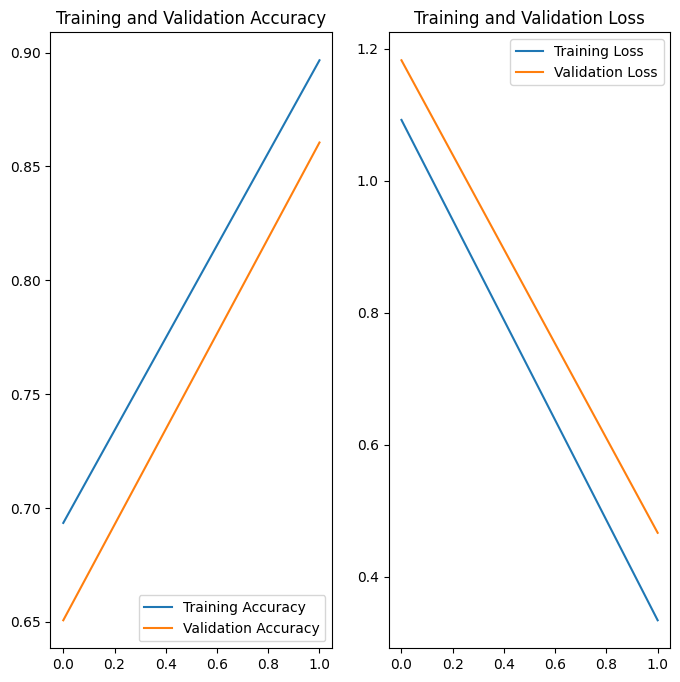

In [ ]:
# train_loss_array,train_acc_array,val_loss_array,val_acc_array
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 模型验证集预测

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
for (img_rgb, y) in test_dataloader:
    img_rgb = img_rgb.to(device)
    y = y.to(device)

    predict_score = base_model_vgg13(img_rgb)
    predict_pro = m_softmax(predict_score)

    predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

    predict_pro_list.append(predict_pro.detach().cpu().numpy())
    predict_list.append(predict_label)
    label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([0.00119568, 0.00244622, 0.06673966, 0.00123741, 0.0051853 ],
       dtype=float32),
 array([9, 0, 2, 4, 2]),
 array([9, 0, 2, 4, 2]))

### 分类报告

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      0.729     0.907     0.808       107
           1      0.947     0.918     0.932        97
           2      0.876     0.963     0.918        81
           3      1.000     0.921     0.959        89
           4      0.958     0.979     0.968        94
           5      0.792     0.966     0.870        87
           6      0.873     0.941     0.906       102
           7      0.828     0.986     0.900        73
           8      0.889     0.488     0.630        82
           9      0.963     0.619     0.754        84

    accuracy                          0.873       896
   macro avg      0.886     0.869     0.865       896
weighted avg      0.884     0.873     0.866       896



### 混淆矩阵

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[97,  1,  0,  0,  2,  5,  0,  0,  1,  1],
       [ 2, 89,  1,  0,  0,  1,  2,  1,  0,  1],
       [ 0,  1, 78,  0,  0,  0,  0,  1,  1,  0],
       [ 4,  1,  0, 82,  1,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0, 92,  1,  0,  0,  1,  0],
       [ 2,  0,  0,  0,  0, 84,  0,  0,  1,  0],
       [ 0,  0,  2,  0,  0,  1, 96,  2,  1,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 72,  0,  0],
       [ 7,  1,  8,  0,  1,  5, 11,  9, 40,  0],
       [21,  1,  0,  0,  0,  8,  1,  1,  0, 52]])

<Axes: >

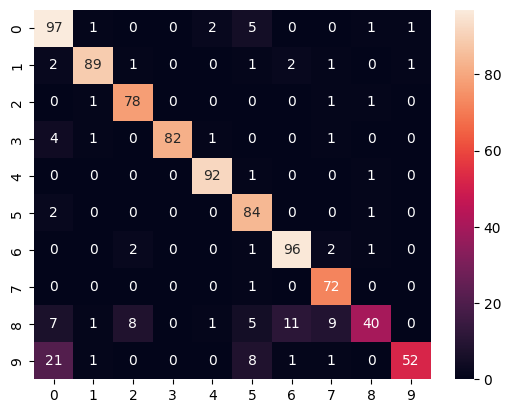

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

<Axes: >

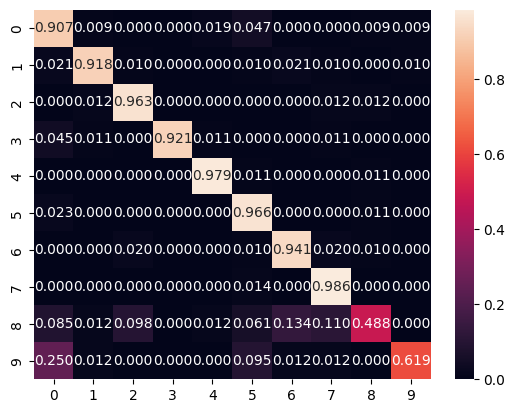

In [ ]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

# 模型 efficientnet

## 构建基础模型

In [ ]:

base_model_efficientnet = models.efficientnet_b0(pretrained=False)

base_model_efficientnet.classifier[-1] = nn.Linear(1280, num_classes)

base_model_efficientnet.to(device)(b_img_rgb.to(device)).shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([8, 10])

In [ ]:
base_model_efficientnet

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## 分配损失函数和优化器

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(base_model_efficientnet.parameters(), lr=1e-3)

## 训练和评估

In [ ]:
epochs = 2
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, base_model_efficientnet, loss_fn, optimizer)

    train_loss, train_correct = test(train_dataloader, base_model_efficientnet, loss_fn)
    test_loss, test_correct = test(test_dataloader, base_model_efficientnet, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)
print("Done!")

Epoch 1
-------------------------------
loss: 2.293696  [    0/ 3588]
loss: 2.272720  [  200/ 3588]
loss: 2.379654  [  400/ 3588]
loss: 2.256952  [  600/ 3588]
loss: 2.336900  [  800/ 3588]
loss: 2.335117  [ 1000/ 3588]
loss: 2.225540  [ 1200/ 3588]
loss: 2.246109  [ 1400/ 3588]
loss: 2.359216  [ 1600/ 3588]
loss: 2.324800  [ 1800/ 3588]
loss: 2.314794  [ 2000/ 3588]
loss: 2.293396  [ 2200/ 3588]
loss: 2.378170  [ 2400/ 3588]
loss: 2.197979  [ 2600/ 3588]
loss: 2.281572  [ 2800/ 3588]
loss: 2.313690  [ 3000/ 3588]
loss: 2.266020  [ 3200/ 3588]
loss: 2.319950  [ 3400/ 3588]
Test Error: 
 Accuracy: 11.9%, Avg loss: 2.300192 

Test Error: 
 Accuracy: 11.7%, Avg loss: 2.303878 

Epoch 2
-------------------------------
loss: 2.319693  [    0/ 3588]
loss: 2.271451  [  200/ 3588]
loss: 2.309106  [  400/ 3588]
loss: 2.270076  [  600/ 3588]
loss: 2.355942  [  800/ 3588]
loss: 2.345785  [ 1000/ 3588]
loss: 2.335045  [ 1200/ 3588]
loss: 2.312439  [ 1400/ 3588]
loss: 2.350885  [ 1600/ 3588]
loss: 

## 可视化训练过程

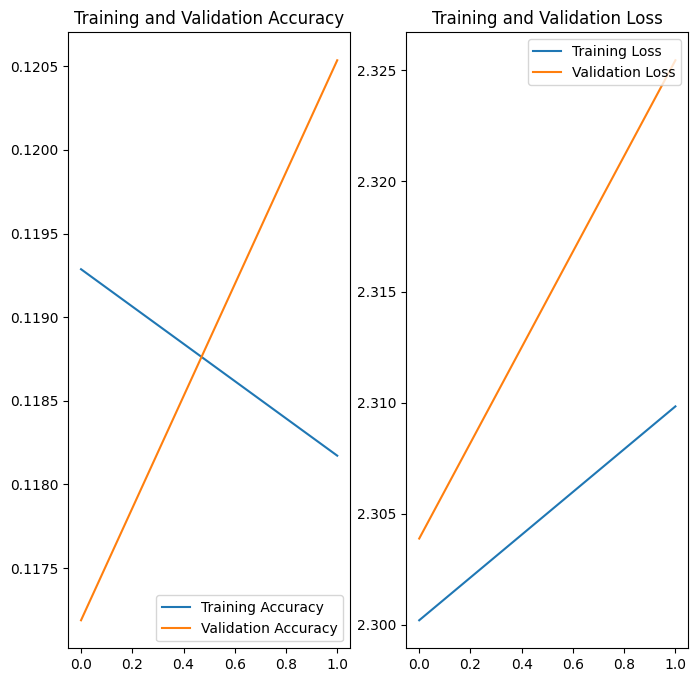

In [ ]:
# train_loss_array,train_acc_array,val_loss_array,val_acc_array
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 模型验证集预测

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
for (img_rgb, y) in test_dataloader:
    img_rgb = img_rgb.to(device)
    y = y.to(device)

    predict_score = base_model_efficientnet(img_rgb)
    predict_pro = m_softmax(predict_score)

    predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

    predict_pro_list.append(predict_pro.detach().cpu().numpy())
    predict_list.append(predict_label)
    label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([0.10755982, 0.09167491, 0.09017024, 0.09088721, 0.09387537],
       dtype=float32),
 array([4, 0, 2, 2, 4]),
 array([9, 0, 2, 4, 2]))

### 分类报告

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      0.140     0.112     0.124       107
           1      0.333     0.021     0.039        97
           2      0.081     0.469     0.137        81
           3      0.100     0.022     0.037        89
           4      0.109     0.234     0.149        94
           5      0.143     0.011     0.021        87
           6      0.000     0.000     0.000       102
           7      0.000     0.000     0.000        73
           8      0.000     0.000     0.000        82
           9      0.119     0.143     0.130        84

    accuracy                          0.099       896
   macro avg      0.102     0.101     0.064       896
weighted avg      0.106     0.099     0.065       896



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 混淆矩阵

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[12,  1, 63,  6, 14,  1,  0,  0,  0, 10],
       [ 5,  2, 49,  1, 27,  0,  0,  0,  0, 13],
       [ 9,  0, 38,  0, 27,  0,  0,  0,  0,  7],
       [ 9,  0, 47,  2, 15,  0,  0,  0,  0, 16],
       [15,  0, 49,  2, 22,  0,  0,  0,  0,  6],
       [ 4,  0, 47,  4, 19,  1,  0,  0,  0, 12],
       [ 9,  1, 54,  0, 28,  2,  0,  0,  0,  8],
       [ 6,  0, 37,  1, 18,  1,  1,  0,  0,  9],
       [ 9,  0, 44,  1, 19,  0,  0,  1,  0,  8],
       [ 8,  2, 44,  3, 13,  2,  0,  0,  0, 12]])

<Axes: >

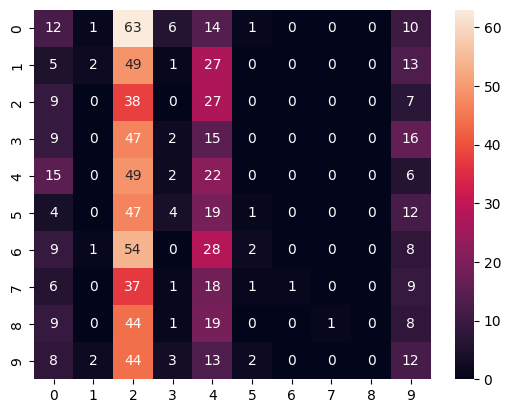

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

<Axes: >

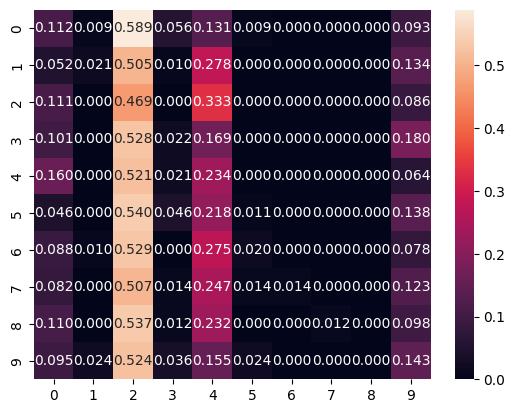

In [ ]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')

# 模型 vit

## 构建基础模型

In [ ]:

base_model_vit_b_16 = models.vit_b_16(pretrained=True)
# base_model_vit_b_16.encoder.layers = base_model_vit_b_16.encoder.layers[:2]
base_model_vit_b_16.heads.head = nn.Linear(768, num_classes)

base_model_vit_b_16.to(device)(b_img_rgb.to(device)).shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 109MB/s]


torch.Size([8, 10])

In [ ]:
base_model_vit_b_16

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

## 分配损失函数和优化器

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(base_model_vit_b_16.parameters(), lr=1e-3)

## 训练和评估

In [ ]:
epochs = 2
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, base_model_vit_b_16, loss_fn, optimizer)

    train_loss, train_correct = test(train_dataloader, base_model_vit_b_16, loss_fn)
    test_loss, test_correct = test(test_dataloader, base_model_vit_b_16, loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_correct)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_correct)
print("Done!")

Epoch 1
-------------------------------
loss: 2.057723  [    0/ 3588]
loss: 2.427675  [  200/ 3588]
loss: 2.191797  [  400/ 3588]
loss: 2.426508  [  600/ 3588]
loss: 1.991763  [  800/ 3588]
loss: 2.208885  [ 1000/ 3588]
loss: 1.714759  [ 1200/ 3588]
loss: 1.665044  [ 1400/ 3588]
loss: 1.842922  [ 1600/ 3588]
loss: 1.738614  [ 1800/ 3588]
loss: 1.540801  [ 2000/ 3588]
loss: 1.993498  [ 2200/ 3588]
loss: 1.690824  [ 2400/ 3588]
loss: 1.356220  [ 2600/ 3588]
loss: 1.588662  [ 2800/ 3588]
loss: 1.273858  [ 3000/ 3588]
loss: 0.870898  [ 3200/ 3588]
loss: 1.153970  [ 3400/ 3588]
Test Error: 
 Accuracy: 75.9%, Avg loss: 1.022518 

Test Error: 
 Accuracy: 72.1%, Avg loss: 1.098174 

Epoch 2
-------------------------------
loss: 0.773977  [    0/ 3588]
loss: 0.801367  [  200/ 3588]
loss: 1.137910  [  400/ 3588]
loss: 0.664430  [  600/ 3588]
loss: 0.689072  [  800/ 3588]
loss: 0.899593  [ 1000/ 3588]
loss: 0.387915  [ 1200/ 3588]
loss: 0.606251  [ 1400/ 3588]
loss: 0.549407  [ 1600/ 3588]
loss: 

## 可视化训练过程

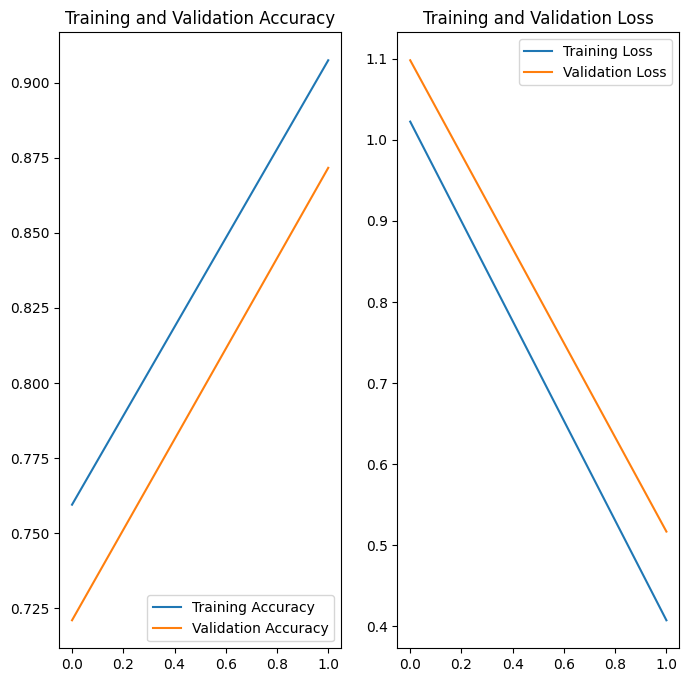

In [ ]:
# train_loss_array,train_acc_array,val_loss_array,val_acc_array
acc = train_acc_list
val_acc = test_acc_list

loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 模型验证集预测

In [ ]:
predict_list = []
label_list = []
predict_pro_list = []
m_softmax = nn.Softmax(dim=1)
for (img_rgb, y) in test_dataloader:
    img_rgb = img_rgb.to(device)
    y = y.to(device)

    predict_score = base_model_vit_b_16(img_rgb)
    predict_pro = m_softmax(predict_score)

    predict_label = np.argmax(predict_score.detach().cpu().numpy(),axis=1)

    predict_pro_list.append(predict_pro.detach().cpu().numpy())
    predict_list.append(predict_label)
    label_list.append(y.detach().cpu().numpy())

predict_pro_array = np.vstack(predict_pro_list)[:,1]
predict_array = np.hstack(predict_list)
label_array = np.hstack(label_list)
predict_pro_array[:5],predict_array[:5],label_array[:5]

(array([0.00637422, 0.06326187, 0.002034  , 0.00523171, 0.00224975],
       dtype=float32),
 array([0, 0, 2, 4, 2]),
 array([9, 0, 2, 4, 2]))

### 分类报告

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(label_array, predict_array,digits=3))

              precision    recall  f1-score   support

           0      0.764     0.785     0.774       107
           1      0.912     0.959     0.935        97
           2      0.860     0.988     0.920        81
           3      0.952     0.899     0.925        89
           4      0.938     0.957     0.947        94
           5      0.964     0.920     0.941        87
           6      0.845     0.912     0.877       102
           7      0.958     0.945     0.952        73
           8      0.891     0.500     0.641        82
           9      0.640     0.762     0.696        84

    accuracy                          0.864       896
   macro avg      0.872     0.863     0.861       896
weighted avg      0.870     0.864     0.861       896



### 混淆矩阵

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(label_array, predict_array)
cnf_matrix

array([[84,  0,  0,  2,  0,  0,  1,  0,  0, 20],
       [ 2, 93,  0,  0,  0,  0,  0,  0,  0,  2],
       [ 0,  0, 80,  0,  0,  0,  1,  0,  0,  0],
       [ 2,  1,  0, 80,  2,  1,  0,  0,  1,  2],
       [ 0,  0,  0,  1, 90,  0,  0,  0,  0,  3],
       [ 3,  0,  0,  0,  0, 80,  0,  1,  0,  3],
       [ 0,  3,  4,  0,  0,  0, 93,  0,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 69,  2,  2],
       [ 4,  3,  9,  1,  4,  0, 14,  2, 41,  4],
       [15,  2,  0,  0,  0,  2,  1,  0,  0, 64]])

<Axes: >

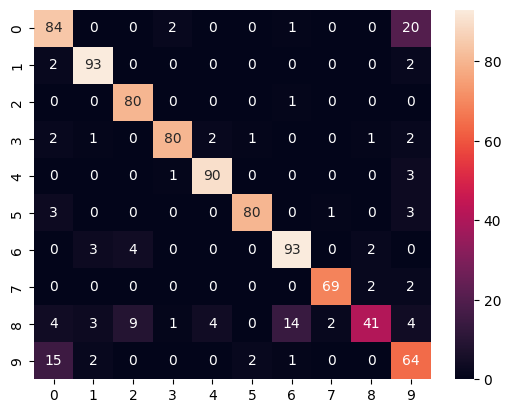

In [ ]:
sns.heatmap(cnf_matrix, annot=True, fmt='g')

<Axes: >

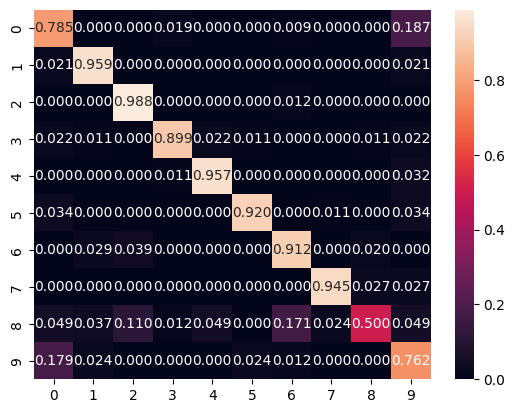

In [ ]:
cm_normalized = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f')